<a href="https://colab.research.google.com/github/project-ida/arpa-e-experiments/blob/neutrons-background-1/tutorials/Eljen-Background-Characterization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="https://nbviewer.org/github/project-ida/arpa-e-experiments/blob/neutrons-background-1/tutorials/Eljen-Background-Characterization.ipynb" target="_parent"><img src="https://nbviewer.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

In [ ]:
pip install ipywidgets

# Eljen Detector Background Characterization

### Prequel - What's an Eljen detector ?

Eljen scintillator detectors work by converting ionizing radiation into visible light. Radiation excites molecules in the plastic; these de-excite and emit photons. The light is detected by a photomultiplier tube (PMT) or Silicon photomultiplier (SiPM), producing an electrical signal proportional to the energy deposited.

## 5 and 2 inch Eljen detector - December 2024/ January 2025

Our goal is to characterize the background radiation as picked up by the 2" and 5" Eljen detectors. In order to do so, we ran the Eljen detectors in question throughout December 2024 and January 2025. We will know chracterize this background---which will be useful for future analysis.

In [14]:
# RUN THIS IF YOU ARE USING GOOGLE COLAB
import sys
import os
!git clone https://github.com/project-ida/arpa-e-experiments.git
sys.path.insert(0,'/content/arpa-e-experiments')
os.chdir('/content/arpa-e-experiments')

Cloning into 'arpa-e-experiments'...
remote: Enumerating objects: 308, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 308 (delta 21), reused 21 (delta 11), pack-reused 265 (from 1)
Receiving objects: 100% (308/308), 29.95 MiB | 8.91 MiB/s, done.
Resolving deltas: 100% (155/155), done.
Updating files: 100% (54/54), done.


In [15]:
# Libraries and helper functions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import ipywidgets as widgets
from IPython.display import display

from IPython.display import Image
from IPython.display import Video
from IPython.display import HTML

# Use our custom helper functions
# - process_data
# - plot_panels
# - plot_panels_with_scatter
# - print_info
from libs.helpers import *

In [16]:
meta = {
    "descriptor" : "Eljen 12-2024" # This will go into the title of all plots
}

## Step 1 - Data Collection

Let's begin by collecting raw data on the Eljen detectors of interest.  

We have collected long-term data on the neutron and gamma counts picked up by our Eljen detectors, from December 14th 2024 00:01:01 to January 23rd, 2025 23:58:59. They are defined as dataframes, which we can manipulate using pandas, below.

In [17]:
neutron_df = pd.read_csv(
    'http://nucleonics.mit.edu/csv-files/eljen-2inch-long-term-1.csv',
    parse_dates=['time'],
    date_format="ISO8601",
    index_col='time'
)

gamma_df = pd.read_csv(
    'http://nucleonics.mit.edu/csv-files/eljen-2inch-long-term-4.csv',
    parse_dates=['time'],
    date_format="ISO8601",
    index_col='time'
)

## Step 2 - Visualizing Neutron and Gamma counts

Now that we have collected the raw data (i.e. electric signal history) that interests us, let us have a look at the measured neutron and gamma counts.

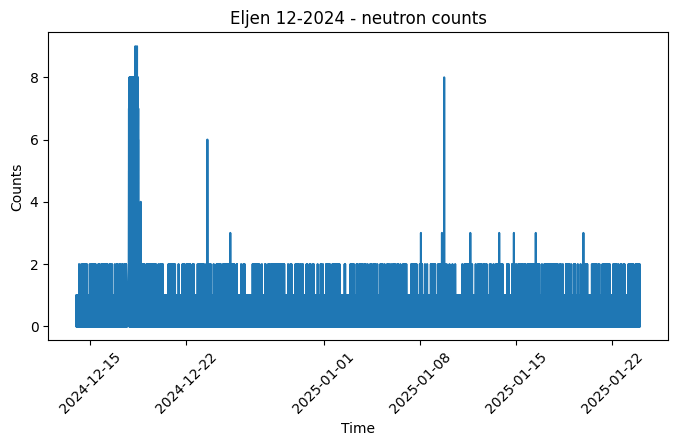

In [18]:
plt.figure(figsize=(8, 4))
plt.plot(neutron_df['Counts'])
plt.xlabel('Time')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.title(f"{meta['descriptor']} - neutron counts")
plt.show()
# plt.savefig("all-neutron-counts-sec.png", dpi=600)

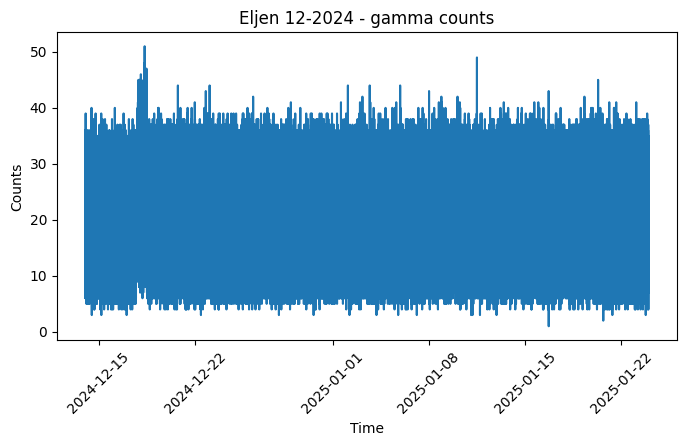

In [19]:
plt.figure(figsize=(8, 4))
plt.plot(gamma_df['Counts'])
plt.xlabel('Time')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.title(f"{meta['descriptor']} - gamma counts")
plt.show()
# plt.savefig("all-gamma-counts-sec.png", dpi=600)

## Step 3 - Resampling data and Removing Neutron burst

The current data is taken about once per second. We'll now aggregate this data to present counts in 1 minute intervals.

Furthermore, we notice in the plot below that we observed a neutron burst on December 18th. This corresponds to a time-period in which we brought a Cf-252 neutron source into the lab (ie the bursts that the detectors are picking up). In order to define a clear background time, we will start collecting data from December 19th.

In [20]:
neutron_df_1_minute = neutron_df.resample('1min').sum()
gamma_df_1_minute = gamma_df.resample('1min').sum()

# Assuming neutron_df_1_minute has a datetime index
start_time = "2024-12-19 00:00:00"
end_time = "2025-01-23 23:59:00"

neutron_df_1_minute_background = neutron_df_1_minute.loc[start_time:end_time]
gamma_df_1_minute_background = gamma_df_1_minute[start_time:end_time]

## Step 4 - Analyzing the Bakground Counts

Now that we have excluded the time before and when the neutron source was introduced, let us have a closer look at our background neutron counts.

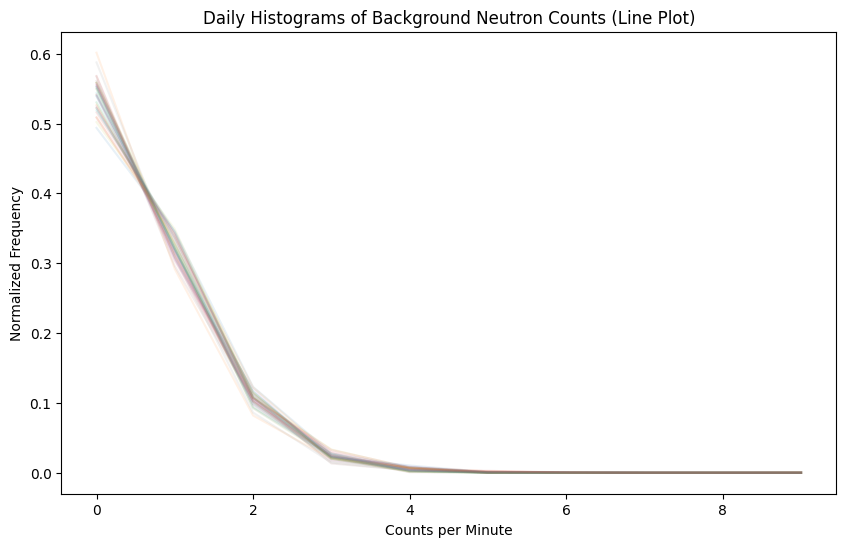

In [21]:
# Ensure the index is datetime
neutron_df_1_minute_background.index = pd.to_datetime(neutron_df_1_minute_background.index)

# Group by day
grouped_by_day = neutron_df_1_minute_background.groupby(neutron_df_1_minute_background.index.date)

# Define bins for the histogram
bins = np.arange(neutron_df_1_minute_background["Counts"].min(),
                 neutron_df_1_minute_background["Counts"].max() + 1, 1)  # Use integer bins

# Plot all histograms as line plots
plt.figure(figsize=(10, 6))

for day, group in grouped_by_day:
    hist_values, bin_edges = np.histogram(group["Counts"], bins=bins, density=True)
    plt.plot(bin_edges[:-1], hist_values, alpha=0.1, label=str(day))

plt.xlabel("Counts per Minute")
plt.ylabel("Normalized Frequency")
plt.title("Daily Histograms of Background Neutron Counts (Line Plot)")
plt.show()

In order to conduct a statistical analysis on these background counts, we need to have an idea of what qualifies as a "significant" (ie significant enough) diversion from background. This will be of interest when trying to determine whether or not we have detected an abnormal number of neutron counts.

### Expected Poisson Distribution

We expect the background neutron counts to follow a Poisson distribution.

Neutron background counts are typically modeled by a Poisson distribution because they arise from random, independent events which occur at a constant average rate over time. This aligns with the conditions under which the Poisson distribution is valid:

- Rare Events: Background neutrons are detected infrequently and individually—each detection is a discrete event.

- Statistical Independence: The arrival of one neutron does not affect the probability of another arriving (no clustering or correlation).

- Constant Rate: Over short timescales (like 1-minute bins), the average background rate is approximately stable.

- Fixed Observation Interval: Counts are measured over uniform time intervals (e.g. per minute).

Under these conditions, the number of neutrons detected in a fixed time interval follows a Poisson distribution with mean λ, where λ is the expected number of events (neutrons) per interval.

The standard deviation is $\sigma = \sqrt{λ}$

We will consider that count is "significantly high" if it exceeds $\lambda + \sqrt{\lambda}\cdot Z$

where $Z = 3$ corresponds to a $3\sigma$ threshold (confidence level ~99.7%)

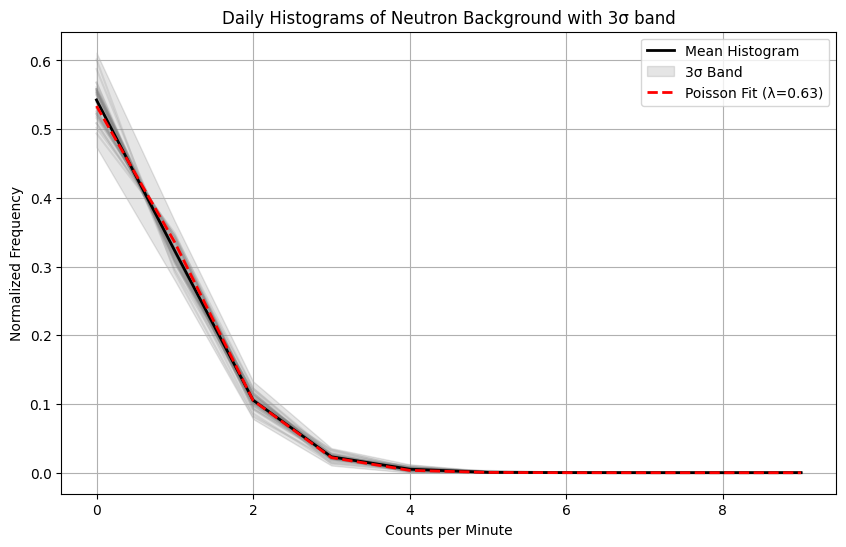

In [22]:
histograms = []
for day, group in grouped_by_day:
    hist_values, bin_edges = np.histogram(group["Counts"], bins=bins, density=True)
    histograms.append(hist_values)

# Convert list to array and compute mean + std across days
histograms = np.array(histograms)
mean_histogram = np.mean(histograms, axis=0)
std_histogram = np.std(histograms, axis=0)

# Estimate Poisson background mean
lambda_ = neutron_df_1_minute_background["Counts"].mean()
threshold_3sigma = lambda_ + 3 * np.sqrt(lambda_)


# Poisson fit
k_values = bin_edges[:-1]  # Use bin centers (left edges)
poisson_pmf = stats.poisson.pmf(k_values, mu=lambda_)

# Normalize Poisson PMF for visual comparison
poisson_pmf_normalized = poisson_pmf / np.sum(poisson_pmf)  # Normalize manually
poisson_pmf_normalized *= np.sum(mean_histogram)  # Match total area to empirical hist

plt.figure(figsize=(10, 6))

# daily histograms
for hist_values in histograms:
    plt.plot(bin_edges[:-1], hist_values, alpha=0.2, color='gray')

# mean histogram
plt.plot(bin_edges[:-1], mean_histogram, color='black', linewidth=2, label='Mean Histogram')

# 3σ band
plt.fill_between(bin_edges[:-1],
                 np.maximum(mean_histogram - 3 * std_histogram, 0),
                 mean_histogram + 3 * std_histogram,
                 color='black', alpha=0.1, label='3σ Band')

# Poisson fit overlay
plt.plot(k_values, poisson_pmf_normalized, 'r--', linewidth=2, label=f'Poisson Fit (λ={lambda_:.2f})')

plt.xlabel("Counts per Minute")
plt.ylabel("Normalized Frequency")
plt.title("Daily Histograms of Neutron Background with 3σ band")
plt.legend()
plt.grid(True)
plt.show()


Let's take a step back to understand what we are looking at here.

The black line corresponds to the average distribution of neutron counts across all days.

The grey shaded area shows the spread of day-to-day variation, with upper and lower bounds at 3 standard deviations above and below the mean. Days that would lie outside this band would be statistically rare under normal conditions (probability < 0.3%). Hence, we may identify neutron bursts in future runs by looking at "outliers" of this grey shaded area.

The red dashed line corresponds to the theoretical distribution assuming that neutron counts follow a Poisson process. We plotted this normalized Poisson ditribution assuming the Poisson paramter $\lambda$ to me the mean of our background data i.e. $\lambda \approx 0.63$. We notice that this fit is remarkably close to our back line. This is reassuring as it shows that our detector has reasonable callibration ie is picking up background as we expect it to.

## Zooming in on outliers

To determine whether a count is "significantly high", we use the well-established normal approximation to the Poisson distribution.

Given a Poisson process with mean rate $ \lambda $, the standard deviation is $ \sqrt{\lambda} $. Under this approximation, an observed count is considered statistically significant at Z standard deviations if:

$\text{Count} > \lambda + Z \cdot \sqrt{\lambda}$

This method is commonly used in radiation measurement and other count-based detection systems, as detailed in:

- G. F. Knoll, *Radiation Detection and Measurement*, 4th ed., Wiley, 2010.

In [ ]:
# Function to update the plot based on Z
def plot_outliers(Z):
    threshold_poisson = lambda_ + Z * np.sqrt(lambda_)
    poisson_outliers = neutron_df_1_minute_background[neutron_df_1_minute_background["Counts"] > threshold_poisson]

    plt.figure(figsize=(14, 5))
    plt.plot(neutron_df_1_minute_background.index, neutron_df_1_minute_background["Counts"],
             label="Counts per Minute", color='blue', linewidth=1)

    plt.scatter(poisson_outliers.index, poisson_outliers["Counts"],
                color='red', label=f"Outliers (> {threshold_poisson:.2f} counts)", zorder=5)

    plt.axhline(threshold_poisson, color='gray', linestyle='--', linewidth=1.5,
                label=f"Z = {Z:.1f} Threshold")

    plt.title(f"Neutron Count Time Series with Z={Z:.1f} Outlier Threshold")
    plt.xlabel("Time")
    plt.ylabel("Counts per Minute")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

z_slider = widgets.IntSlider(value=3, min=1, max=10, step=1,
                             description='Z-score:', continuous_update=False)
# Connect the slider to the function
interactive_plot = widgets.interactive_output(plot_outliers, {'Z': z_slider})

# Display the slider and plot
display(z_slider, interactive_plot)


Let us now perform the same analysis for gamma counts.

In [ ]:
# Precompute Poisson mean for gamma background
lambda_gamma = gamma_df_1_minute_background["Counts"].mean()

# Define the plotting function
def plot_gamma_outliers(Z):
    threshold_poisson = lambda_gamma + Z * np.sqrt(lambda_gamma)
    poisson_outliers = gamma_df_1_minute_background[gamma_df_1_minute_background["Counts"] > threshold_poisson]

    plt.figure(figsize=(14, 5))
    plt.plot(gamma_df_1_minute_background.index, gamma_df_1_minute_background["Counts"],
             label="Gamma Counts per Minute", color='purple', linewidth=1)

    plt.scatter(poisson_outliers.index, poisson_outliers["Counts"],
                color='orange', label=f"{len(poisson_outliers)} Outliers (> {threshold_poisson:.2f} counts)", zorder=5)

    plt.axhline(threshold_poisson, color='gray', linestyle='--', linewidth=1.5,
                label=f"Z = {Z} Threshold")

    plt.title(f"Gamma Count Time Series with Z={Z} Outlier Threshold")
    plt.xlabel("Time")
    plt.ylabel("Gamma Counts per Minute")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create integer slider for Z from 1 to 10
z_slider_gamma = widgets.IntSlider(value=3, min=1, max=10, step=1,
                                   description='Z-score:', continuous_update=False)

# Create interactive output
interactive_plot_gamma = widgets.interactive_output(plot_gamma_outliers, {'Z': z_slider_gamma})

# Display the slider and plot
display(z_slider_gamma, interactive_plot_gamma)
